In [23]:
import pandas as pd
from statistics  import pvariance
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA, TruncatedSVD, DictionaryLearning
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [24]:
def clustering_method(dataframe, method, K=3):
    
    cols = [x for x in dataframe.columns if 'id_' in x]
    X = dataframe[cols]

    if method == 'kmeans':
        kmeans = KMeans(n_clusters = K, random_state=30).fit(X)
        dataframe['cluster'] = kmeans.labels_
    elif method == 'mean_shift':
        ms = MeanShift(bandwidth=K, bin_seeding=True, random_state=30).fit(X)
        dataframe['cluster'] = ms.labels_
    elif method == 'gaussian_mixture':
        dataframe['cluster'] = GaussianMixture(n_components=K, covariance_type='spherical', random_state=30).fit_predict(X)
        
    return dataframe

In [25]:
def decomposition_method(dataframe, method):
    
    cols = [x for x in dataframe.columns if 'id_' in x]
    X = dataframe[cols]
    
    if method == 'pca':
        dataframe[['x', 'y', 'z']] = PCA(n_components=3).fit_transform(X)
    elif method == 'truncated_svd':
        dataframe[['x', 'y', 'z']] = TruncatedSVD(n_components=3).fit_transform(X)
    elif method == 'dictionary_learning':
        dataframe[['x', 'y', 'z']] = DictionaryLearning(n_components=3, transform_algorithm='lasso_lars').fit_transform(X)
        
    return dataframe

In [13]:
clustering_ms = ['kmeans', 'gaussian_mixture']
decomposition_ms = ['pca']
KS = [3]

# Embeddings Dot Product

In [14]:
act_desc = pd.read_csv('output_files/Activity_description.csv', sep='|', index_col=0)

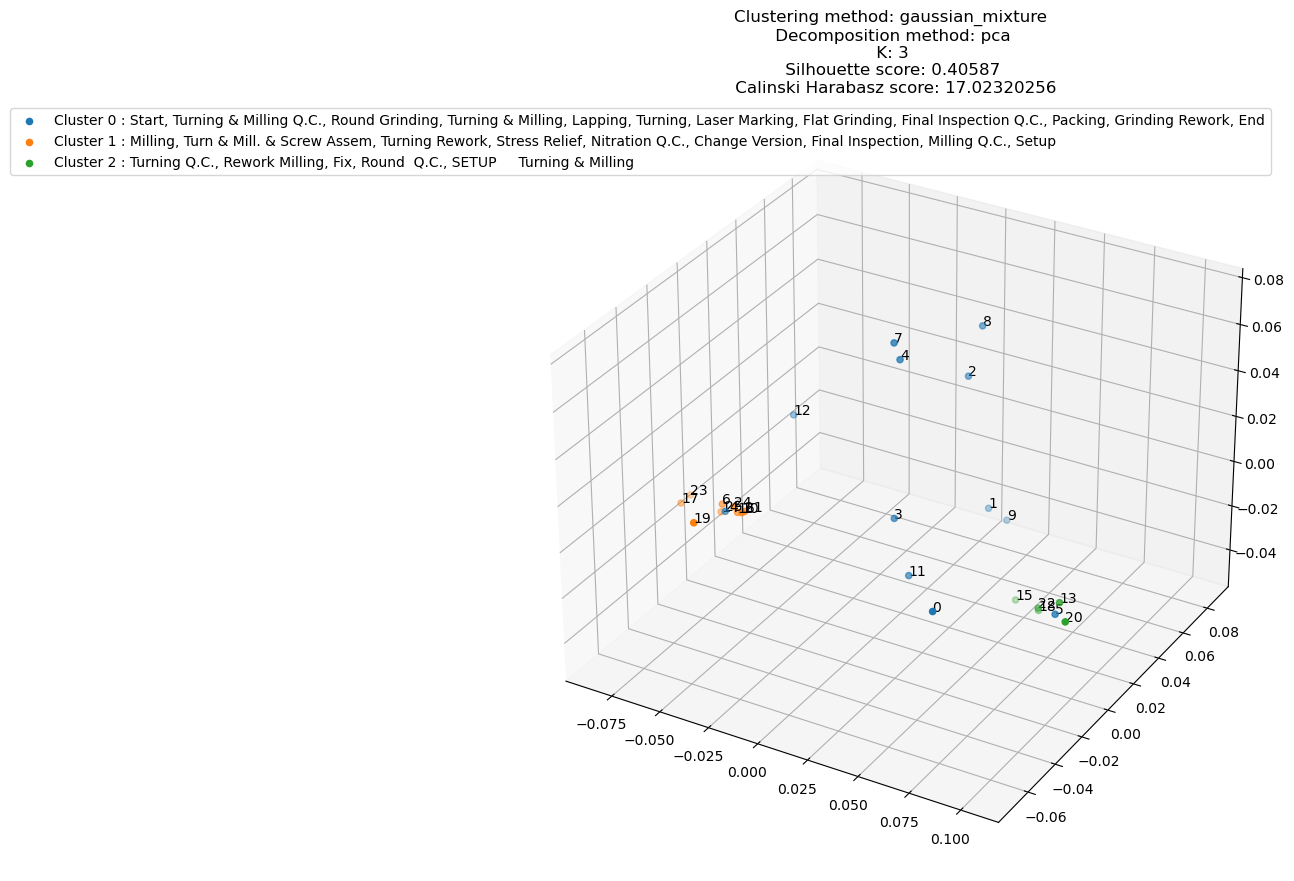

In [36]:
df_embeddings_dp = pd.read_csv('embeddings/ac_DP_Production.emb', header=None)
n_cols = len(df_embeddings_dp.columns)
df_embeddings_dp.columns = ['id', 'task_name'] + ['id_{}'.format(idx) for idx in range(1, n_cols-1)]
df_embeddings_dp['task_name'] = df_embeddings_dp['task_name'].str.lstrip()
df_embeddings = df_embeddings_dp.merge(act_desc, how='left', on='task_name')

metrics = []
for clustering_m in clustering_ms:
    for decomposition_m in decomposition_ms:
        for K in KS:
            df_embeddings_tmp = clustering_method(df_embeddings_dp, clustering_m, K=K)
            df_embeddings_tmp = decomposition_method(df_embeddings_tmp, decomposition_m)
            s_score = silhouette_score(df_embeddings_tmp[['x', 'y', 'z']], df_embeddings_tmp['cluster'], metric='euclidean')
            ch_score = calinski_harabasz_score(df_embeddings_tmp[['x', 'y', 'z']], df_embeddings_tmp['cluster'])
            metrics.append([clustering_m, decomposition_m, K, s_score, ch_score])

metrics_df = pd.DataFrame(data= metrics, columns = ['clustering_method', 'decomposition_method', 'number_clusters', 'silhouette_score', 'calinski_harabasz_score'])
best = metrics_df.sort_values(by=['silhouette_score', 'calinski_harabasz_score'], ascending=True).head(1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
clusters_variance = []

best_clust_method = best['clustering_method'].values[0]
best_decomp_method = best['decomposition_method'].values[0]
best_K = best['number_clusters'].values[0]
sil_score = np.round(best['silhouette_score'].values[0], 5)
cal_har_score = np.round(best['calinski_harabasz_score'].values[0], 8)

df_embeddings_dp_best = clustering_method(df_embeddings_dp, best_clust_method, K=best_K)
df_embeddings_dp_best = decomposition_method(df_embeddings_dp, best_decomp_method)
legends = []

for idx, cluster in enumerate(df_embeddings_dp_best['cluster'].drop_duplicates().values):

    df_embedding_tmp = df_embeddings_dp_best.loc[df_embeddings_dp_best['cluster']==cluster, :]
    ax.scatter(df_embedding_tmp['x'], df_embedding_tmp['y'], df_embedding_tmp['z'], colors[idx])
    legends.append(', '.join([str(x) for x in list(df_embedding_tmp['task_name'])]))

for i, item in enumerate(df_embeddings_dp_best['id']):
    ax.text(df_embeddings_dp_best['x'].iloc[i], df_embeddings_dp_best['y'].iloc[i], df_embeddings_dp_best['z'].iloc[i], item)

title = 'Clustering method: {} \n Decomposition method: {} \n K: {} \n Silhouette score: {} \n Calinski Harabasz score: {}'
plt.title(title.format(best_clust_method, best_decomp_method, best_K, sil_score, cal_har_score))
plt.legend(['Cluster {} : {}'.format(i,x) for i, x in enumerate(legends)])

# Embeddings Word2Vec

## Fast-text

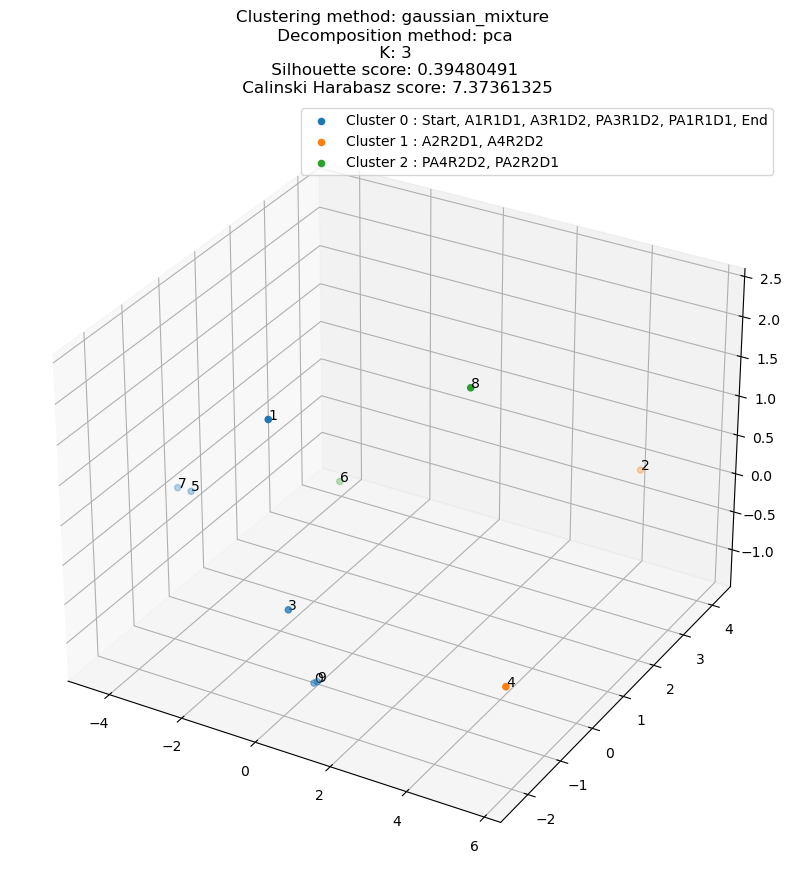

In [16]:
df_embeddings_w2v = pd.read_csv('embeddings/ac_W2V_SinteticLog.emb', header=None)
df_embeddings_w2v.columns = ['id', 'task_name', 'id_1', 'id_2', 'id_3', 'id_4']
df_embeddings_w2v['task_name'] = df_embeddings_w2v['task_name'].str.lstrip()
df_embeddings_w2v = df_embeddings_w2v.merge(act_desc, how='left', on='task_name')

metrics = []
for clustering_m in clustering_ms:
    for decomposition_m in decomposition_ms:
        for K in KS:
            df_embeddings_tmp = clustering_method(df_embeddings_w2v, clustering_m, K=K)
            df_embeddings_tmp = decomposition_method(df_embeddings_tmp, decomposition_m)
            s_score = silhouette_score(df_embeddings_tmp[['x', 'y', 'z']], df_embeddings_tmp['cluster'], metric='euclidean')
            ch_score = calinski_harabasz_score(df_embeddings_tmp[['x', 'y', 'z']], df_embeddings_tmp['cluster'])
            metrics.append([clustering_m, decomposition_m, K, s_score, ch_score])

metrics_df = pd.DataFrame(data= metrics, columns = ['clustering_method', 'decomposition_method', 'number_clusters', 'silhouette_score', 'calinski_harabasz_score'])
best = metrics_df.sort_values(by=['silhouette_score', 'calinski_harabasz_score'], ascending=True).head(1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
clusters_variance = []

best_clust_method = best['clustering_method'].values[0]
best_decomp_method = best['decomposition_method'].values[0]
best_K = best['number_clusters'].values[0]
sil_score = np.round(best['silhouette_score'].values[0], 8)
cal_har_score = np.round(best['calinski_harabasz_score'].values[0], 8)

df_embeddings_w2v_best = clustering_method(df_embeddings_w2v, best_clust_method, K=best_K)
df_embeddings_w2v_best = decomposition_method(df_embeddings_w2v, best_decomp_method)
legends = []

for idx, cluster in enumerate(df_embeddings_w2v_best['cluster'].drop_duplicates().values):

    df_embedding_tmp = df_embeddings_w2v_best.loc[df_embeddings_w2v_best['cluster']==cluster, :]
    ax.scatter(df_embedding_tmp['x'], df_embedding_tmp['y'], df_embedding_tmp['z'], colors[idx])
    legends.append(', '.join([str(x) for x in list(df_embedding_tmp['task_name'])]))

for i, item in enumerate(df_embeddings_w2v_best['id']):
    ax.text(df_embeddings_w2v_best['x'].iloc[i], df_embeddings_w2v_best['y'].iloc[i], df_embeddings_w2v_best['z'].iloc[i], item)

title = 'Clustering method: {} \n Decomposition method: {} \n K: {} \n Silhouette score: {} \n Calinski Harabasz score: {}'
plt.title(title.format(best_clust_method, best_decomp_method, best_K, sil_score, cal_har_score))
plt.legend(['Cluster {} : {}'.format(i,x) for i, x in enumerate(legends)])

# Silhouette Score : 
$
(b - a) / max(a, b)
$

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample.

# Calinski Harabasz Score : 

El índice CH (también conocido como criterio de relación de varianza ) es una medida de qué tan similar es un objeto a su propio grupo (cohesión) en comparación con otros grupos (separación). Aquí la cohesión se estima en función de las distancias desde los puntos de datos en un grupo a su centroide de grupo y la separación se basa en la distancia de los centroides de grupo desde el centroide global.

# Comentarios

Tener en cuenta una descripcion de la actividad, el rol que la ejecuta, el timestamp de cuando se ejecuta (momento del día), la posicion de cuando se ejcuta (posicion en la traza) y la distribución de tiempos (tiempo de procesamiento con su distribucion) de la tarea.

Lo anterior usando unicamente la particion de training.

Incorporar el Word2Vec que ya fue generado y hacer la comparación con el cluster generado.

Volver a generar las corridas para ver que si se generen los embeddings con los diferentes metodos.
No volver a generar los tiempos, actividades y recursos sino leerlos desde el log procesado.
Ponerle los atributos al cluster.
Correr con mas logs.
En el paper estan todos los logs.

Despues de invocar _split_timeline() guardar el tamaño de las trazas tanto para test y train, y las eliminadas. Se podría usar el train y validation.

read_inputs() linea 86 se lee el log y luego se divide (linea 92)

Revisar el times_generator() en la linea 191 para que el ac_index y el log tenga la misma cantidad de actividades.

Revisar el masterduration en log_reader.py para ver como se esta discretizando los tiempos. Basado en duración, revisar como se hace la discretizacion de los tiempo.

Tener que son cada métrica que se esta usando para el clustering.

Agregar la media y la desviacion del tiempo de procesamiento, y para la posicion en la traza la media.

Correrlo con todos los logs disponibles. Hacer un consolidado con los resultados de precision de deepsimulator. (Carpeta de output files, archivo SE_...)

Imprimir trazas del concatenamiento de las actividades, tiempos y roles.

## Cambios para el miercoles

Probar con logs sinteticos y mirar que las tareas se agrupen de acuerdo a la similitud.

## Cambios para el Lunes

Preguntarle a Federico como se discretizaron los tiempos.

MANDATORY: Ajustar la discretizacion de tiempos generando los intervalos a partir del comportamiento del log.
Sacar la media de duracion de las actividades, tomar el max y min de la duracion y dividir eso en el tiempo total del log.
En el metodo de federico esta predefinido el numero de 34 los intervalos y eso hace que las categorias de intervalos de tiempos esten practicamente continuos.

SI ALCANZO: Imprimir ambas entradas de los embeddings (concatenar solo la actividad, recurso y tiempo) (concatenar todos los tiempos, actividades y recursos de una misma instancia en orden usando una ventana de N).

MANDATORY: Correrlo con el log de production (lo que ya se tiene con la construccion de las entradas de los embeddings actual).

Usar el end_timestamp - start_timestamp para la duración de la tarea.

Discretizar usando sklearn.

Correr con los parametros definidos.

Implementar el concatenar todas las tripletas para una oracion.

# 12/10/2022

Implementar weighthing dimensions con el peso asociado a cada rol y duración para calcular el final embedding.

Investigar si hay algun tipo de embeddings multidimensional. (Transformers)

## Weighting embeddings

In [1]:
import pandas as pd
import numpy as np

log = pd.read_csv('log.csv', sep='|')

In [13]:
log['start_timestamp'] = pd.to_datetime(log['start_timestamp'], infer_datetime_format=True)
log['end_timestamp'] = pd.to_datetime(log['end_timestamp'], infer_datetime_format=True)

log['duration'] = log.apply(lambda x: (x['end_timestamp'] - x['start_timestamp']).total_seconds(), axis= 1)

n_bins = int((np.max(log['duration']) - np.min(log['duration']))/(np.mean(log['duration'])))
print('The number of intervals are: {}'.format(n_bins))
log['duration_cat'] = pd.qcut(log['duration'], n_bins, labels=False)

The number of intervals are: 4


In [20]:
count_roles = log[['task', 'user']].value_counts().reset_index().rename(columns={0: 'conteo'})
count_duration = log[['task', 'duration_cat']].value_counts().reset_index().rename(columns={0: 'conteo'})

# Pruebas modelos

In [3]:
import gensim
import os
import pandas as pd
import numpy as np
import utils.support as sup
import math
import itertools
from datetime import datetime

In [7]:
w2v_method = 'fast_text'
sent = [['Turning & Milling', 'ID4932', '3'], ['Turning & Milling', 'ID4932', '0'], ['Turning & Milling', 'ID4167', '0'], ['Turning & Milling', 'ID4167', '2'], ['Turning & Milling Q.C.', 'ID4163', '2'],
        ['Laser Marking', 'ID0998', '0'], ['Lapping', 'ID4882', '1'], ['Lapping', 'ID4882', '0'], ['Round Grinding', 'ID4445', '3'], ['Round Grinding', 'ID4445', '2'], ['Final Inspection Q.C.', 'ID4493', '1'], 
        ['Final Inspection Q.C.', 'ID4493', '2'], ['Final Inspection Q.C.', 'ID4493', '1'], ['Packing', 'ID4820', '1'], ['Turning & Milling', 'ID4219', '3'], ['Turning & Milling', 'ID4219', '2'], 
        ['Turning & Milling', 'ID0997', '2'], ['Turning & Milling', 'ID0997', '2'], ['Turning & Milling Q.C.', 'ID4287', '0'], ['Turning & Milling', 'ID0997', '2'], ['Turning & Milling', 'ID4219', '3'], 
        ['Turning & Milling', 'ID4794', '2'], ['Turning & Milling', 'ID0997', '2'], ['Turning & Milling', 'ID0997', '3'], ['Turning & Milling Q.C.', 'ID4287', '1'], ['Turning & Milling', 'ID0997', '1'], 
        ['Turning & Milling Q.C.', 'ID4287', '0'], ['Turning & Milling', 'ID0997', '0'], ['Turning & Milling', 'ID4219', '2'], ['Turning & Milling Q.C.', 'ID4287', '1'], ['Turning & Milling Q.C.', 'ID4287', '1'], 
        ['Laser Marking', 'ID0998', '1'], ['Lapping', 'ID4882', '1'], ['Lapping', 'ID0998', '1'], ['Round Grinding', 'ID4528', '0'], ['Round Grinding', 'ID4528', '3'], ['Round Grinding', 'ID4445', '1'], 
        ['Round Grinding', 'ID4445', '0'], ['Round Grinding', 'ID4287', '0'], ['Round Grinding', 'ID4287', '2'], ['Round Grinding', 'ID4445', '0'], ['Final Inspection Q.C.', 'ID4287', '2'], 
        ['Final Inspection Q.C.', 'ID4287', '0'], ['Packing', 'ID4820', '1'], ['Turning & Milling', 'ID4794', '3'], ['Turning & Milling', 'ID4529', '2'], ['Turning & Milling Q.C.', 'ID4287', '2'], 
        ['Turning & Milling', 'ID4529', '2'], ['Turning & Milling Q.C.', 'ID4287', '1'], ['Laser Marking', 'ID0998', '1'], ['Flat Grinding', 'ID4528', '1'], ['Flat Grinding', 'ID0420', '1'], 
        ['Lapping', 'ID0420', '0'], ['Lapping', 'ID0420', '0'], ['Round Grinding', 'ID4385', '2'], ['Round Grinding', 'ID4385', '2'], ['Round Grinding', 'ID0420', '2'], ['Round Grinding', 'ID4872', '2'], 
        ['Final Inspection Q.C.', 'ID4287', '3'], ['Packing', 'ID4820', '1'], ['Final Inspection Q.C.', 'ID4287', '0'], ['Turning & Milling', 'ID4932', '3'], ['Turning & Milling', 'ID4167', '0'], 
        ['Turning & Milling Q.C.', 'ID4618', '1'], ['Turning & Milling', 'ID4529', '1'], ['Turning & Milling', 'ID4529', '3'], ['Turning & Milling', 'ID4932', '2'], ['Turning & Milling Q.C.', 'ID4618', '1'], 
        ['Turning & Milling Q.C.', 'ID4618', '0'], ['Laser Marking', 'ID0998', '0'], ['Round Grinding', 'ID4355', '1'], ['Round Grinding', 'ID4355', '0'], ['Round Grinding', 'ID4385', '3'], 
        ['Round Grinding', 'ID4445', '0'], ['Round Grinding', 'ID4445', '2'], ['Final Inspection Q.C.', 'ID4618', '2'], ['Packing', 'ID4491', '1'], ['Turning & Milling', 'ID4529', '3'], 
        ['Turning & Milling', 'ID4429', '3'], ['Turning & Milling', 'ID4794', '3'], ['Turning & Milling Q.C.', 'ID4493', '1'], ['Laser Marking', 'ID0998', '1'], ['Lapping', 'ID0998', '1'], 
        ['Round Grinding', 'ID4872', '2'], ['Round Grinding', 'ID4872', '2'], ['Round Grinding', 'ID4355', '2'], ['Round Grinding', 'ID4355', '0'], ['Round Grinding', 'ID4385', '2'], 
        ['Final Inspection Q.C.', 'ID4493', '1'], ['Turning & Milling', 'ID4167', '3'], ['Turning & Milling', 'ID4167', '2'], ['Turning & Milling Q.C.', 'ID4618', '2'], ['Turning & Milling', 'ID4794', '1'], 
        ['Turning & Milling', 'ID4794', '3'], ['Turning & Milling', 'ID4794', '2'], ['Turning & Milling', 'ID4429', '3'], ['Turning & Milling', 'ID4529', '0'], ['Turning & Milling', 'ID4794', '3'], 
        ['Turning & Milling Q.C.', 'ID4618', '0'], ['Turning & Milling', 'ID4167', '2'], ['Laser Marking', 'ID4932', '1'], ['Round Grinding', 'ID4445', '0'], ['Round Grinding', 'ID4445', '1'], 
        ['Round Grinding', 'ID0420', '2'], ['Round Grinding', 'ID0420', '3'], ['Round Grinding', 'ID4355', '3'], ['Round Grinding', 'ID0420', '2'], ['Round Grinding', 'ID4445', '0'], 
        ['Turning & Milling Q.C.', 'ID4618', '0'], ['Round Grinding', 'ID4385', '1'], ['Round Grinding', 'ID4385', '2'], ['Round Grinding', 'ID4445', '3'], ['Final Inspection Q.C.', 'ID4618', '3'], 
        ['Packing', 'ID4820', '1'], ['Turning & Milling', 'ID4641', '3'], ['Turning & Milling', 'ID3846', '3'], ['Turning & Milling', 'ID4641', '3'], ['Turning & Milling', 'ID4641', '3'], 
        ['Turning & Milling', 'ID4132', '3'], ['Turning & Milling', 'ID3846', '1'], ['Turning & Milling', 'ID4641', '3'], ['Turning & Milling', 'ID4132', '2'], ['Turning & Milling Q.C.', 'ID4493', '3'], 
        ['Laser Marking', 'ID0998', '0'], ['Lapping', 'ID0998', '2'], ['Round Grinding', 'ID4385', '3'], ['Round Grinding', 'ID4385', '2'], ['Round Grinding', 'ID4445', '3'], 
        ['Final Inspection Q.C.', 'ID4493', '2'], ['Grinding Rework', 'ID4528', '3'], ['Grinding Rework', 'ID4872', '2'], ['Grinding Rework', 'ID4528', '2'], ['Grinding Rework', 'ID4528', '2'], 
        ['Packing', 'ID4820', '1'], ['Final Inspection Q.C.', 'ID4493', '1'], ['Turning & Milling', 'ID4794', '3'], ['Turning & Milling', 'ID0997', '2'], ['Turning & Milling', 'ID0997', '3'], 
        ['Turning & Milling', 'ID4429', '0'], ['Turning & Milling', 'ID4794', '3'], ['Turning & Milling', 'ID4529', '3'], ['Turning & Milling Q.C.', 'ID4618', '0'], ['Laser Marking', 'ID0998', '1'], 
        ['Lapping', 'ID0998', '3'], ['Final Inspection Q.C.', 'ID4618', '2'], ['Packing', 'ID4820', '1'], ['Turning & Milling', 'ID4167', '3'], ['Turning & Milling', 'ID4529', '3'], 
        ['Turning & Milling Q.C.', 'ID4618', '3'], ['Turning & Milling', 'ID4932', '1'], ['Turning & Milling', 'ID4932', '1'], ['Turning & Milling', 'ID4794', '3'], ['Turning & Milling', 'ID4794', '3'], 
        ['Turning & Milling', 'ID4932', '3'], ['Turning & Milling Q.C.', 'ID4529', '1'], ['Turning & Milling Q.C.', 'ID4618', '1'], ['Turning & Milling Q.C.', 'ID4618', '0'], 
        ['Turning & Milling Q.C.', 'ID4167', '0'], ['Laser Marking', 'ID4932', '0'], ['Round Grinding', 'ID4445', '1'], ['Round Grinding', 'ID0420', '2'], ['Round Grinding', 'ID0420', '2'], 
        ['Round Grinding', 'ID4445', '3'], ['Round Grinding', 'ID4445', '2'], ['Round Grinding', 'ID4445', '0'], ['Round Grinding', 'ID4445', '2'], ['Turning & Milling Q.C.', 'ID4618', '0'], 
        ['Round Grinding', 'ID0420', '2'], ['Round Grinding', 'ID0420', '2'], ['Final Inspection Q.C.', 'ID4618', '0'], ['Final Inspection Q.C.', 'ID4618', '2'], ['Round Grinding', 'ID0420', '0'], 
        ['Round Grinding', 'ID0420', '0'], ['Final Inspection Q.C.', 'ID4618', '1'], ['Packing', 'ID4820', '1'], ['Turning & Milling Q.C.', 'ID4618', '0'], ['Laser Marking', 'ID4355', '0'], 
        ['Laser Marking', 'ID4445', '0'], ['Lapping', 'ID4882', '1'], ['Lapping', 'ID0998', '3'], ['Final Inspection Q.C.', 'ID4618', '3'], ['Final Inspection Q.C.', 'ID4618', '1'], 
        ['Packing', 'ID4820', '1'], ['Turning & Milling', 'ID4794', '1'], ['Turning & Milling', 'ID4794', '3'], ['Turning & Milling', 'ID4794', '2'], ['Turning & Milling Q.C.', 'ID4618', '1'], 
        ['Turning & Milling', 'ID4529', '3'], ['Turning & Milling', 'ID4794', '3'], ['Turning & Milling Q.C.', 'ID4618', '0'], ['Turning & Milling Q.C.', 'ID4618', '0'], ['Laser Marking', 'ID0998', '0'],
        ['Lapping', 'ID0998', '2'], ['Lapping', 'ID0998', '2'], ['Final Inspection Q.C.', 'ID4618', '3'], ['Packing', 'ID4820', '1'], ['Final Inspection Q.C.', 'ID4618', '1'], 
        ['Turning & Milling', 'ID4794', '3'], ['Turning & Milling', 'ID4794', '2'], ['Turning & Milling', 'ID4167', '3'], ['Turning & Milling', 'ID4529', '0'], ['Turning & Milling Q.C.', 'ID4618', '1'], 
        ['Turning & Milling', 'ID4794', '0'], ['Turning & Milling', 'ID4794', '3'], ['Turning & Milling', 'ID4167', '3'], ['Turning & Milling', 'ID4529', '0'], ['Turning & Milling Q.C.', 'ID4618', '0'],
        ['Turning & Milling Q.C.', 'ID4618', '0'], ['Flat Grinding', 'ID0998', '3'], ['Flat Grinding', 'ID4618', '0'], ['Laser Marking', 'ID4872', '2'], ['Laser Marking', 'ID4355', '1'], 
        ['Lapping', 'ID0998', '0'], ['Lapping', 'ID0998', '3'], ['Final Inspection Q.C.', 'ID4618', '3'], ['Packing', 'ID4820', '1'], ['Turning & Milling', 'ID0997', '3'], 
        ['Turning & Milling', 'ID0997', '2'], ['Turning & Milling', 'ID4445', '1'], ['Turning & Milling Q.C.', 'ID4618', '0'], ['Turning & Milling Q.C.', 'ID4618', '1'], ['Laser Marking', 'ID0998', '0'],
        ['Lapping', 'ID0998', '2'], ['Laser Marking', 'ID0998', '1'], ['Lapping', 'ID0998', '1'], ['Final Inspection Q.C.', 'ID4618', '2'], ['Packing', 'ID4820', '1'], 
        ['Final Inspection Q.C.', 'ID4618', '1'], ['Turning & Milling', 'ID4641', '2'], ['Turning & Milling', 'ID3846', '3'], ['Turning & Milling', 'ID3846', '1'], ['Turning & Milling', 'ID3846', '0'], 
        ['Turning & Milling', 'ID4641', '3'], ['Turning & Milling Q.C.', 'ID4493', '0'], ['Laser Marking', 'ID0998', '1'], ['Lapping', 'ID0998', '2'], ['Round Grinding', 'ID4528', '0'], 
        ['Round Grinding', 'ID4528', '2'], ['Final Inspection Q.C.', 'ID4493', '1'], ['Packing', 'ID4820', '1'], ['Final Inspection Q.C.', 'ID4493', '1'], ['Turning & Milling Q.C.', 'ID4493', '0'], 
        ['Turning & Milling', 'ID4429', '1'], ['Laser Marking', 'ID4872', '1'], ['Lapping', 'ID4528', '0'], ['Round Grinding', 'ID4528', '1'], ['Round Grinding', 'ID4528', '2'], 
        ['Round Grinding', 'ID4528', '3'], ['Lapping', 'ID4528', '0'], ['Round Grinding', 'ID4528', '1'], ['Round Grinding', 'ID4528', '2'], ['Round Grinding', 'ID4528', '2'], 
        ['Round Grinding', 'ID4528', '0'], ['Round Grinding', 'ID4528', '3'], ['Round Grinding', 'ID4528', '2'], ['Round Grinding', 'ID4528', '2'], ['Round Grinding', 'ID4528', '2'], 
        ['Final Inspection Q.C.', 'ID4493', '3'], ['Packing', 'ID4820', '1'], ['Final Inspection Q.C.', 'ID4493', '0'], ['Turning & Milling', 'ID4794', '3'], ['Turning & Milling', 'ID4529', '3'], 
        ['Turning & Milling', 'ID4529', '2'], ['Turning & Milling', 'ID4794', '3'], ['Turning & Milling', 'ID4167', '0'], ['Turning & Milling', 'ID4167', '0'], ['Turning & Milling Q.C.', 'ID4618', '1'],
        ['Turning & Milling', 'ID4167', '3'], ['Turning & Milling', 'ID4794', '3'], ['Turning & Milling Q.C.', 'ID4618', '0'], ['Turning & Milling', 'ID4167', '3'], ['Turning & Milling', 'ID4794', '0'],
        ['Turning & Milling', 'ID4932', '3'], ['Turning & Milling', 'ID4167', '3'], ['Turning & Milling Q.C.', 'ID4618', '1'], ['Turning & Milling Q.C.', 'ID4618', '0'], ['Laser Marking', 'ID4445', '2'],
        ['Round Grinding', 'ID4445', '0'], ['Round Grinding', 'ID4445', '3'], ['Round Grinding', 'ID4528', '0'], ['Turning & Milling Q.C.', 'ID4618', '3'], ['Round Grinding', 'ID4385', '3'],
        ['Round Grinding', 'ID4355', '2'], ['Round Grinding', 'ID4445', '3'], ['Round Grinding', 'ID0420', '3'], ['Round Grinding', 'ID4445', '1'], ['Round Grinding', 'ID0420', '0'], 
        ['Round Grinding', 'ID4445', '0'], ['Round Grinding', 'ID4445', '0'], ['Round Grinding', 'ID0420', '3'], ['Round Grinding', 'ID4355', '3'], ['Round Grinding', 'ID4618', '1'], 
        ['Final Inspection Q.C.', 'ID4618', '3'], ['Final Inspection Q.C.', 'ID4618', '1'], ['Packing', 'ID4820', '1'], ['Turning & Milling', 'ID4794', '3'], ['Turning & Milling', 'ID4429', '0'], 
        ['Turning & Milling', 'ID4529', '0'], ['Turning & Milling Q.C.', 'ID4618', '0'], ['Turning & Milling', 'ID4794', '3'], ['Turning & Milling Q.C.', 'ID4618', '2'], ['Nitration Q.C.', 'ID4618', '0'], 
        ['Laser Marking', 'ID0998', '0'], ['Lapping', 'ID0998', '1'], ['Final Inspection Q.C.', 'ID4618', '3'], ['Final Inspection Q.C.', 'ID4618', '1'], ['Packing', 'ID4820', '1'], 
        ['Turning & Milling', 'ID4932', '2'], ['Turning & Milling', 'ID4932', '3'], ['Turning & Milling Q.C.', 'ID4493', '2'], ['Laser Marking', 'ID4882', '1'], ['Round Grinding', 'ID4109', '3'], 
        ['Lapping', 'ID4872', '0'], ['Round Grinding', 'ID4493', '1'], ['Round Grinding', 'ID4355', '2'], ['Lapping', 'ID0998', '2'], ['Lapping', 'ID0998', '0'], ['Lapping', 'ID4882', '0'], 
        ['Round Grinding', 'ID4355', '2'], ['Final Inspection Q.C.', 'ID4493', '2'], ['Final Inspection Q.C.', 'ID4493', '2'], ['Packing', 'ID4820', '1'], ['Turning & Milling', 'ID4429', '1'], 
        ['Turning & Milling', 'ID4429', '1'], ['Turning & Milling', 'ID4167', '2'], ['Turning & Milling Q.C.', 'ID4287', '2'], ['Turning & Milling', 'ID4794', '2'], ['Turning & Milling', 'ID4794', '3'],
        ['Turning & Milling Q.C.', 'ID4287', '2'], ['Laser Marking', 'ID0998', '1'], ['Flat Grinding', 'ID0998', '1'], ['Lapping', 'ID0998', '1'], ['Final Inspection Q.C.', 'ID4287', '2']]
        
ac_index = {'Turning & Milling Q.C.': 1, 'Round Grinding': 2, 'Turning & Milling': 3, 'Lapping': 4, 'Turning': 5, 'Milling': 6, 'Laser Marking': 7, 'Flat Grinding': 8, 'Final Inspection Q.C.': 9, 
            'Turn & Mill. & Screw Assem': 10, 'Packing': 11, 'Grinding Rework': 12, 'Turning Q.C.': 13, 'Turning Rework': 14, 'Rework Milling': 15, 'Stress Relief': 16, 'Nitration Q.C.': 17, 'Fix': 18,
            'Change Version': 19, 'Round  Q.C.': 20, 'Final Inspection': 21, 'SETUP     Turning & Milling': 22, 'Milling Q.C.': 23, 'Setup': 24, 'Start': 0, 'End': 25}

In [8]:
if w2v_method == 'skipgram':
    # train model Skipgram
    model = gensim.models.Word2Vec(sent, vector_size = 6, min_count=0, sg=1)
elif w2v_method == 'cbow':
    # train model CBOW
    model = gensim.models.Word2Vec(sent, vector_size = 6, min_count=0, sg=0)
elif w2v_method == 'fast_text':
    # train model Fast-text
    model = gensim.models.FastText(sent, vector_size = 6, min_count=0)

nrEpochs = 10
for epoch in range(nrEpochs):
    if epoch % 20 == 0:
        print('Now training epoch %s word2vec' % epoch)
    model.train(sent, start_alpha=0.025, epochs=nrEpochs, total_examples=model.corpus_count)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

keys_sorted = [x[0].replace(' ', '') for x in sorted(ac_index.items(), key=lambda x: x[1], reverse=False)]
ac_weights = model.wv[keys_sorted]

Now training epoch 0 word2vec


In [16]:
model.wv['Risa']

array([ 0.0162613 , -0.03477756,  0.00118497, -0.0299188 ,  0.02378768,
        0.00529216], dtype=float32)

## Pruebas unir resultados

In [1]:
from glob import glob
import pandas as pd

In [56]:
output_files = glob('output_files/ac_*.csv')

file = pd.read_csv(output_files[0])
df = file[['metric', 'sim_val']].set_index('metric').T.reset_index(drop=True)
df['embedding_method'] = 'Dop product' if output_files[0].split('\\')[-1].split('_')[1] == 'DP' else 'Word2Vec'
df['log_name'] = output_files[0].split('\\')[-1].split('_')[-1].split('.')[0]

if len(output_files[0].split('\\')[-1].split('_'))>3:
    df['input_method'] = ' '.join(output_files[0].split('\\')[-1].split('_')[2:-1])
else:
    df['input_method'] = 'No aplica'

for file_name in output_files[1:]:
    file = pd.read_csv(file_name)
    df_tmp = file[['metric', 'sim_val']].set_index('metric').T.reset_index(drop=True)
    df_tmp['embedding_method'] = 'Dop product' if file_name.split('\\')[-1].split('_')[1] == 'DP' else 'Word2Vec'

    if len(file_name.split('\\')[-1].split('_'))>3:
        df_tmp['input_method'] = ' '.join(file_name.split('\\')[-1].split('_')[2:-1])
    else:
        df_tmp['input_method'] = 'No aplica'

    df_tmp['log_name'] = file_name.split('\\')[-1].split('_')[-1].split('.')[0]
    df = pd.concat([df, df_tmp])

df.to_csv('output_files/summary_stats.csv', sep='|', index=False)